## Tutorial on how to use the drift-diffusion simulation approximation

### Compile the bernoulli cython file (this only needs to be run once)

We compile the Bernoulli function with Cython to improve the speed of the computation

1. Find your python path

In [1]:
import sys
print(sys.executable)

/Applications/Xcode.app/Contents/Developer/usr/bin/python3


2. Run the following line of code. It should create athe following folder and files:
    - a folder named build
    - a file named cbernoulli.c

    If you get an error, replace `python` with the python path from above

In [2]:
!python setup.py build_ext --inplace

zsh:1: command not found: python


### Import python packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from Device import Device
from Simulation import Simulation
from matplotlib.colors import LogNorm
# There has to be a parameter file called 'params.py' in the same directory as the script

### Create a new device based on the parameter file

First we create a new device. The parameters of the device are defined in the params.py file. The only parameter that needs to be passed to the object of the Device class is the temperature.

In [4]:
## Define the temperature of the device
temperature = 300.0 

device = Device(temp=temperature)


### Create new simulation

Now we create a new simulation, which takes the device as an input. If we want to simulate a transient simulation, we also have to pass a numpy time array. If we want to simulate a capacitance frequency simulation, we have to pass a numpy array containing the frequencies.

#### Transient simulations

In [5]:
timesteps = np.logspace(-3, 1) # Define time array from 1ms to 10s

simulation = Simulation(device, timesteps=timesteps)

simulation.calc_impedance_vs_t() # Call this to calculate the capacitance and current vs time

We can now plot different device properties. First we plot the capacitance and the current transients. To access the capcitances and currents, we simply call `simulation.Ct_Cs` or `simulation.Jt`.

Text(0.5, 1.0, 'Current transient')

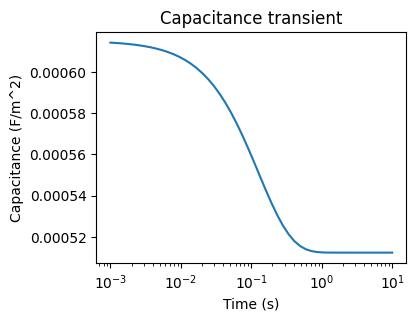

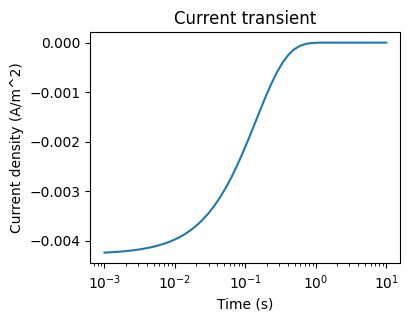

In [6]:
## Plot the capacitance vs time
plt.figure(figsize=(4, 3))
plt.plot(simulation.timesteps, simulation.Ct_Cs, label='Capacitance')
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Capacitance (F/m^2)')
plt.title('Capacitance transient')

## Plot the current vs time
plt.figure(figsize=(4, 3))
plt.plot(simulation.timesteps, simulation.Jt, label='Capacitance')
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Current density (A/m^2)')
plt.title('Current transient')


#### Capacitance frequency simulations

In order to create a capacitance frequency simulation, we have to pass an array with the frequencies to the `calc_impedance_vs_freq` function. We additionally have to set the `consider_cations` variable to `True` to make sure that ions are considered when computing the AC solution

Text(0.5, 1.0, 'Capacitance frequency')

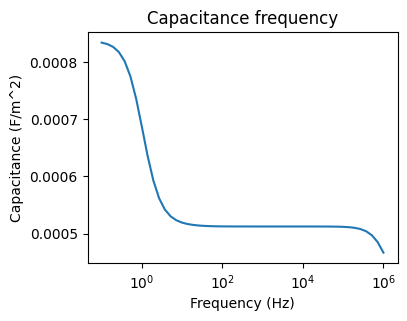

In [7]:
frequencies = np.logspace(-1, 6) # Frequency array from 0.1Hz to 1MHz
simulation = Simulation(device) # Create a new simulation object
simulation.consider_cations = True # Activate cations
simulation.calc_impedance_vs_freq(freqs=frequencies) # Call this to calculate the capacitance vs. frequency

## Plot the capacitance vs frequency
plt.figure(figsize=(4, 3))
plt.plot(frequencies, simulation.Cf_Cs, label='Capacitance')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Capacitance (F/m^2)')
plt.title('Capacitance frequency')

### Plotting potential and carriers

Now we focus on plotting the potential, and density of accumulated charges. 
First, we again create a transient simulation

In [8]:
timesteps = np.logspace(-3, 1) # Define time array from 1ms to 10s

simulation = Simulation(device, timesteps=timesteps)

simulation.calc_impedance_vs_t() # Call this to calculate the capacitance and current vs time

We can then easily access the potential of the device with `simulation.pot` which is a 2D array dependent on the time and position.

(50, 160)


<AxesSubplot: xlabel='Position (m)', ylabel='Potential (V)'>

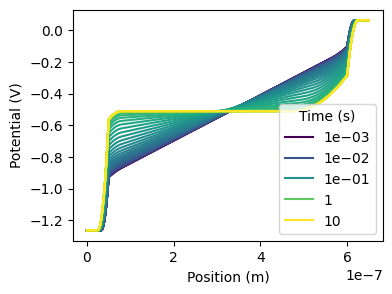

In [9]:
time_mesh, position_mesh = np.meshgrid(simulation.timesteps, simulation.position_steps, indexing='ij')

print(simulation.pot.shape)


plt.figure(figsize=(4, 3))
df = pd.DataFrame({'Potential (V)': simulation.pot.flatten(), 'Time (s)': time_mesh.flatten(), 'Position (m)': position_mesh.flatten()})

sns.lineplot(data=df, x='Position (m)', y='Potential (V)', hue='Time (s)', palette='viridis', hue_norm=LogNorm())

# plt.xlabel('Position (m)')
# plt.ylabel('Potential (V)')

We can also plot the net charge density through the device. For this, we first have to call `simulation.calc_densities()`

<AxesSubplot: xlabel='Position (m)', ylabel='Net density (m^-3)'>

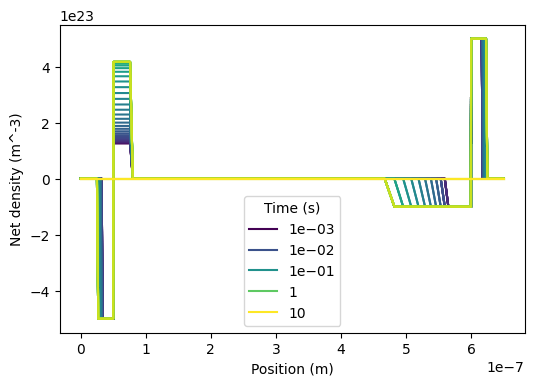

In [10]:
simulation.calc_densities()

time_mesh, position_mesh = np.meshgrid(simulation.timesteps, simulation.position_steps, indexing='ij')
plt.figure(figsize=(6, 4))

print()

df = pd.DataFrame({'Net density (m^-3)': simulation.net_density.flatten(), 'Time (s)': time_mesh.flatten(), 'Position (m)': position_mesh.flatten()})

sns.lineplot(data=df, x='Position (m)', y='Net density (m^-3)', hue='Time (s)', palette='viridis', hue_norm=LogNorm())



Other accessible properties are the valence band energy with `simulation.E_vb` and conduction band energy `simulation.E_cb`, the width `simulation.w2_t` and densities `simulation.n2_t` of the different layers for e.g. the ionic accumulation layer:

Text(0, 0.5, 'Width of accumulation region (m)')

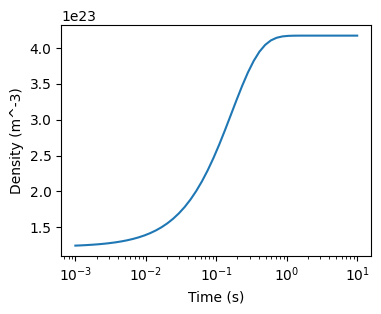

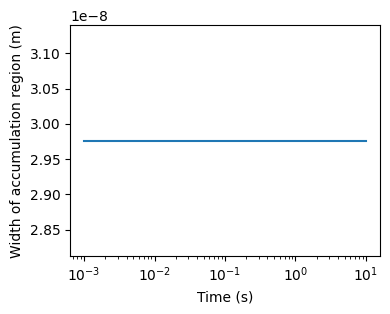

In [11]:
plt.figure(figsize=(4, 3))
plt.plot(simulation.timesteps, simulation.n2_t)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Density (m^-3)')

plt.figure(figsize=(4, 3))
plt.plot(simulation.timesteps, simulation.w2_t)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Width of accumulation region (m)')


To compute the electrical charge densities, we first have to call `simulation.calc_densities()`. Then, we can access the electron and hole density with `n_dc` and `p_dc`. 

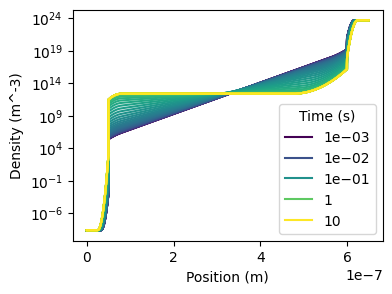

In [12]:
time_mesh, position_mesh = np.meshgrid(simulation.timesteps, simulation.position_steps, indexing='ij')
simulation.calc_densities()

plt.figure(figsize=(4, 3))
df = pd.DataFrame({'Density (m^-3)': simulation.n_dc.flatten(), 'Time (s)': time_mesh.flatten(), 'Position (m)': position_mesh.flatten()})
sns.lineplot(data=df, x='Position (m)', y='Density (m^-3)', hue='Time (s)', palette='viridis', hue_norm=LogNorm())
plt.yscale('log')

Similarly, the complex AC densities and potential can be accessed with `simualtion.n_ac`, `simualtion.p_ac`, `simualtion.psi_ac`. 

### Sweeping of parameters

We can also easily sweep parameters to, for example, fit measurements. 
We again start by defining a device 

In [13]:
## Define the temperature of the device
temperature = 300.0 
device = Device(temp=temperature)

If we now want to compute the different techniques for different ion densities, we simply loop through the ion density parameter:

For the capacitance transients:

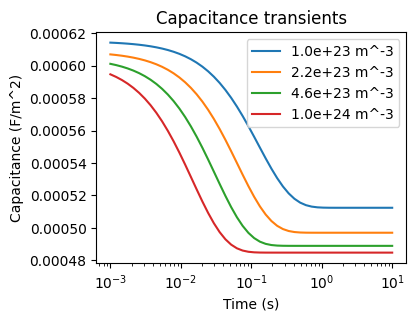

In [14]:
n_ions = np.logspace(23, 24, 4) # Define the ion density array from 10^23 to 10^24
timesteps = np.logspace(-3, 1) # Define time array from 1ms to 10s

plt.figure(figsize=(4, 3))
for n_ion in n_ions:
    device.n_ion = n_ion # Set ion density
    simulation = Simulation(device, timesteps)
    simulation.calc_impedance_vs_t()
    plt.plot(timesteps, simulation.Ct_Cs, label=f'{n_ion:.1e} m^-3') 
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Capacitance (F/m^2)')
plt.title('Capacitance transients')
plt.legend()


For the current transients:

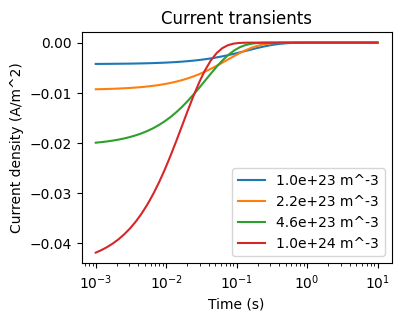

In [15]:
n_ions = np.logspace(23, 24, 4) # Define the ion density array from 10^23 to 10^24
timesteps = np.logspace(-3, 1) # Define time array from 1ms to 10s

plt.figure(figsize=(4, 3))
for n_ion in n_ions:
    device.n_ion = n_ion # Set ion density
    simulation = Simulation(device, timesteps)
    simulation.calc_impedance_vs_t()
    plt.plot(timesteps, simulation.Jt, label=f'{n_ion:.1e} m^-3') 
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Current density (A/m^2)')
plt.title('Current transients')
plt.legend()


And finally for the capacitance frequency measurements

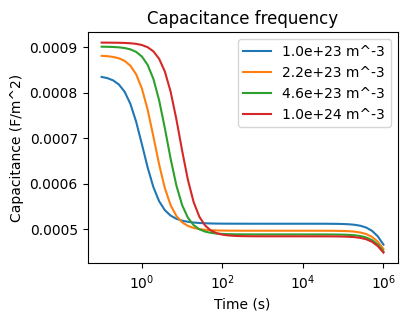

In [16]:
n_ions = np.logspace(23, 24, 4) # Define the ion density array from 10^23 to 10^24
frequencies = np.logspace(-1, 6) # Define time array from 1ms to 10s

plt.figure(figsize=(4, 3))
for n_ion in n_ions:
    device.n_ion = n_ion # Set ion density
    simulation = Simulation(device )
    simulation.consider_cations = True
    simulation.calc_impedance_vs_freq(frequencies)
    plt.plot(frequencies, simulation.Cf_Cs, label=f'{n_ion:.1e} m^-3') 
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Capacitance (F/m^2)')
plt.title('Capacitance frequency')
plt.legend()


Have fun!